In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

# Exploratory Climate Analysis

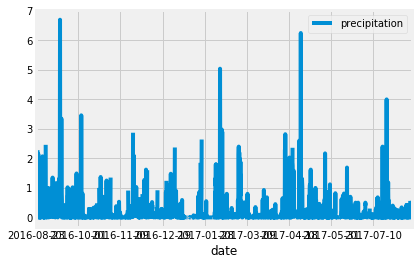

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
prevYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prevYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [14]:
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


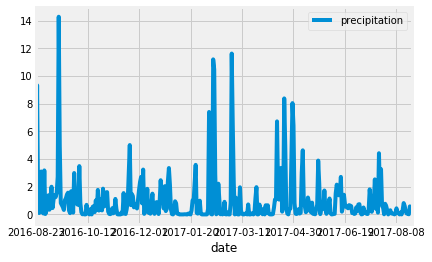

In [15]:
#test_sumRain tests if grouping the sum of rainfall by the date for all stations is a more accurate visualization.
test_sumRain = pd.DataFrame(results, columns=['date', 'precipitation'])
test_sumRain.dropna(inplace=True)
test_sumRain.reset_index(inplace=True)
test_sumRain = pd.DataFrame(test_sumRain.groupby(['date']).sum())
test_sumRain = test_sumRain.drop(['index'], axis=1)

test_sumRain.plot()

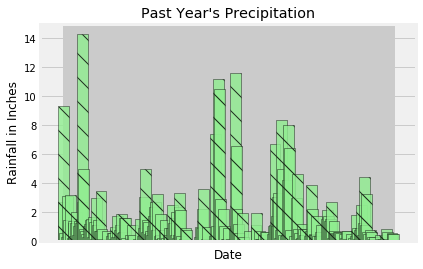

In [16]:
import matplotlib.patheffects as path_effects
x = test_sumRain.index
y = test_sumRain['precipitation']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='lightgreen', edgecolor="black", fill=True, hatch='\\', tick_label='', width=12, alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Rainfall in Inches")
plt.title("Past Year's Precipitation")
plt.show()

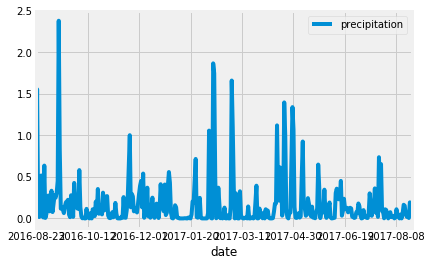

In [17]:
#test_avgRain tests if grouping the average rainfall by the date for all stations is a more accurate visualization.
test_avgRain = pd.DataFrame(results, columns=['date', 'precipitation'])
test_avgRain.dropna(inplace=True)
test_avgRain.reset_index(inplace=True)
test_avgRain = pd.DataFrame(test_avgRain.groupby(['date']).mean())
test_avgRain = test_avgRain.drop(['index'], axis=1)

test_avgRain.plot()

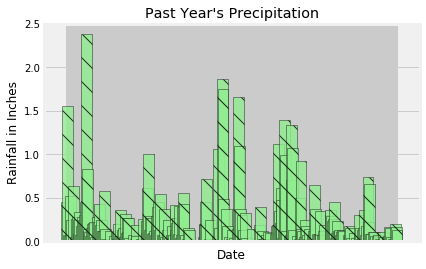

In [18]:
x = test_avgRain.index
y = test_avgRain['precipitation']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='lightgreen', edgecolor="black", fill=True, hatch='\\', tick_label='', width=12, alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Rainfall in Inches")
plt.title("Past Year's Precipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()
#test_sumRain.describe()
#test_avgRain.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
unqStations = session.query(Station.station).distinct(Station.station).count()
print(f"There are {unqStations} unique stations.")

There are 9 unique stations.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#Direct query:
#engine.execute('SELECT station, count(station) FROM Measurement GROUP BY station ORDER BY count(station) DESC').fetchall()

#Wrapped query:
print("The most active stations are:\n\n\n    [Station]  [Reports]")
activeStations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activeStations

The most active stations are:


    [Station]  [Reports]


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


topStation = str([station[0] for station in activeStations[:1]])
topStation = "".join(e for e in topStation if e.isalnum())
#print(topStation)


#topStationStats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
print(f"The weather temp stats for the the most active station ({topStation}) are:\n\n\n [Min.] [Max.]       [Avg.]")
topStationStats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter_by(station=topStation).all()
topStationStats


The weather temp stats for the the most active station (USC00519281) are:


 [Min.] [Max.]       [Avg.]


[(54.0, 85.0, 71.66378066378067)]

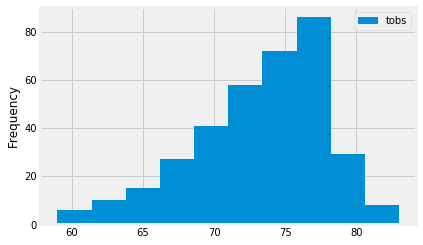

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#activeTOBS = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
#activeTOBS
#If this differed at all we could make a new var like topStation to be known as topTOB for use,
#but since no entries are missing let's just use the existing var as it'd be the same.


# This is off. I tried each station ID manually without luck
topStation12Months = session.query(Measurement.tobs).filter_by(station=topStation).filter(Measurement.date >= prevYear).order_by(Measurement.date.desc()).all()
tobs_df = pd.DataFrame(topStation12Months, columns=['tobs'])
#tobs_df.set_index('date', inplace=True)
#tobs_df = tobs_df.sort_values('date')
tobs_df.plot.hist()

![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Are these the correct dates?: 1 year prior to the example above? Don't match the solution
print(calc_temps('2011-02-28', '2011-03-05'))

#If not, this and everything using this are wrong:
priorYearStats = calc_temps('2011-02-28', '2011-03-05')

[(61.0, 69.75510204081633, 75.0)]


Min: 61.0
Max: 69.76
Avg: 75.0


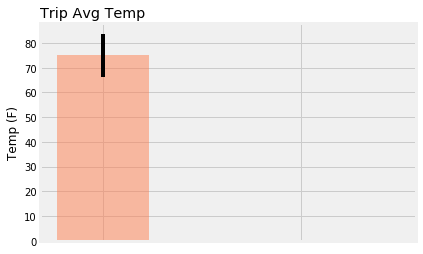

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


vacaMIN = str(np.round([stat[0] for stat in priorYearStats[:1]], 2))
vacaMIN = float("".join(e for e in vacaMIN if e in ('.') or e.isalnum()))
print(f"Min: {vacaMIN}")

vacaMAX = str(np.round([stat[1] for stat in priorYearStats[:1]], 2))
vacaMAX = float("".join(e for e in vacaMAX if e in ('.') or e.isalnum()))
print(f"Max: {vacaMAX}")

vacaAVG = str(np.round([stat[2] for stat in priorYearStats[:1]], 2))
vacaAVG = float("".join(e for e in vacaAVG if e in ('.') or e.isalnum()))
print(f"Avg: {vacaAVG}")

#can't get bar to be skinny like example solution
plt.bar([0, 3], [vacaAVG, 0], tick_label='', width=[1.4, 3], yerr=[(vacaMAX - vacaMIN), 0], color='coral', alpha=0.5)
plt.title("Trip Avg Temp", loc='left')
plt.ylabel("Temp (F)")
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_rain(start_date, end_date):
    return session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).\
                         desc()).\
                            all()

priorYearRain = calc_rain('2011-02-28', '2011-03-05')
rainDF = pd.DataFrame(priorYearRain, columns=['station', 'total_rainfall'])
#rainDF

def calc_stations(singleStation):
    return session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Station.station == singleStation).first()

rain_station_list = []
for singleStation in rainDF['station']:
    singleInfo = calc_stations(singleStation)
    rain_station_list.append(singleInfo)
    
stationDF = pd.DataFrame(rain_station_list)

RainfallSum_DF = pd.merge(rainDF, stationDF, on='station', how='left')
RainfallSum_DF.set_index('station', inplace=True)
RainfallSum_DF

,total_rainfall,name,latitude,longitude,elevation
station,,,,,
USC00518838,2.33,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
USC00519281,2.23,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00519523,2.19,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,1.96,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00516128,1.45,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00513117,1.44,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519397,1.38,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00511918,0.63,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
vaca_dates = []
normals = []

# Set the start and end date of the trip
from datetime import datetime

start_dt = datetime.strptime('2012-02-28', '%Y-%m-%d')
end_dt = datetime.strptime('2012-03-05', '%Y-%m-%d')

# Use the start and end date to create a range of dates
import datetime

trip_dates = [start_dt + datetime.timedelta(days=x) for x in range(0, (end_dt-start_dt).days)]

# Stip off the year and save a list of %m-%d strings
    
for date in trip_dates:
    each = date.strftime("%m-%d")
    vaca_dates.append(each)

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in vaca_dates:
    #normal = date, daily_normals(date)
    normal = daily_normals(date)
    normals.append(normal)
#normals

In [30]:
tuple_MINS = []
tuple_MAXS = []
tuple_AVGS = []

def calc_tuple_stats(normals):
    i = 0
    for each in normals:
        tuple_raw = str(np.round([normal[0] for normal in normals[i:]], 0))
        tuple_raw = "".join(e for e in tuple_raw if e in ('.') or e.isalnum())
        tuple_MINS.append(float(tuple_raw[:2]))
        tuple_MAXS.append(float(tuple_raw[3:5]))
        tuple_AVGS.append(float(tuple_raw[6:8]))
        i = i + 1
        
calc_tuple_stats(normals)

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normalsDF = pd.DataFrame()
normalsDF.insert(0, "AVG_Temp", tuple_AVGS)
normalsDF.insert(0, "MAX_Temp", tuple_MAXS)
normalsDF.insert(0, "MIN_Temp", tuple_MINS)
normalsDF.insert(0, "Date", vaca_dates)
normalsDF.set_index('Date', inplace=True)
normalsDF

,MIN_Temp,MAX_Temp,AVG_Temp
Date,,,
02-28,65.0,71.0,80.0
02-29,67.0,72.0,79.0
03-01,64.0,70.0,76.0
03-02,61.0,70.0,78.0
03-03,60.0,70.0,78.0
03-04,57.0,69.0,77.0


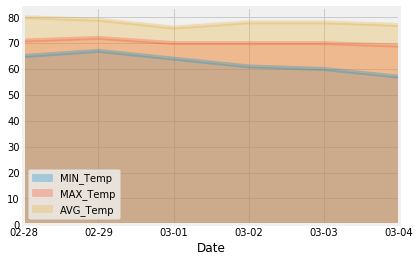

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
normalsDF.plot.area(stacked=False, alpha=0.3)

In [33]:
# Step 2 - Climate App with Flask

In [34]:
#index.html
<!DOCTYPE html>
<html lang="en">

<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <meta http-equiv="X-UA-Compatible" content="ie=edge">
  <title>Document</title>
</head>

<body>
  <section>
    <h1>API Index</h1>
    <hr>
    <br>
    <ul>
      <li><a href="/api/v1.0/precipitation">Precipitation Data</a></li>
      <li><a href="/api/v1.0/stations">Stations Data</a></li>
      <li><a href="/api/v1.0/tobs">Temperature Data (TOBS)</a> </li>
      <li><a href="/api/v1.0/<start>">Weather Data by Starting Date</a></li>
      <li><a href="/api/v1.0/<start>/<end>">Weather Data by Range of Dates</a></li>
    </ul>
    <br>
    <h3>API Operations GUI</h3>
    <hr>
    <br>
    <ul>
      <li><a href="/search">Search Weather by Date(s)</a> </li>
    </ul>
    <br>
  </section>
</body>

</html>

SyntaxError: invalid syntax (<ipython-input-34-82ba93ad74d4>, line 2)

In [ ]:
#datesearch.html
<!DOCTYPE html>
<html lang="en">

<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <meta http-equiv="X-UA-Compatible" content="ie=edge">
  <title>Search by Date Range</title>
</head>

<body>
  <h1>Data By Date Range</h1>
  <hr/>
  {% if error %}
  <h2>Errors Encountered</h2>
  <p>{{ error }}</p>
  <hr/>
  {% endif %}
  {% if results %}
  <h2>Results</h2>
    <table>
      <tr>
        <th>min_temp</th>
        <th>avg_temp</th>
        <th>max_temp</th>
      </tr>
    {% for item in results %}
      <tr>
        <td>{{ item['min_temp'] }}</td>
        <td>{{ item['avg_temp'] }}</td>
        <td>{{ item['max_temp'] }}</td>
      </tr>
    {% endfor %}
    </table>
  <hr/>
  {% endif %}
  <h2>Search Weather by Custom Date(s)</h2>
  <form action="/search" method="POST">
    <div><label for="start_date">Starting Date:</label><input type="date" id="start_date" name="start_date"></div>
    <div><label for="end_date">Ending Date:</label><input type="date" id="end_date" name="end_date", value="2017-08-23"></div>
    <div class="button"><button type="submit">Search Range</button></div>
  </form>

</body>

</html>



In [ ]:
#api_app.py

from flask import Flask, jsonify, redirect, url_for, render_template, request, flash, escape
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime
import time

import colors
from flask import g, request
from rfc3339 import rfc3339

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

app = Flask(__name__)
prevYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Define what to do when a user hits the index route
@app.route("/", methods=['GET'])
def home():
    return redirect(url_for('static', filename='index.html'))


@app.route("/api/v1.0/precipitation")
def precip():
    # Build the query.
    prevYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    precip_results = session.query(Measurement.date, Measurement.prcp).filter(
        Measurement.date >= prevYear).all()

    # Convert the query results to a Dictionary using date as the key and prcp as the value.
    all_precip_stats = []
    for date, precipitation in precip_results:
        precip_dict = {}
        precip_dict["date"] = date
        precip_dict["precipitation"] = precipitation
        all_precip_stats.append(precip_dict)

    # Return the JSON representation of your dictionary.
    return jsonify(all_precip_stats)


@app.route("/api/v1.0/stations")
def stations():
    # Build the query.
    station_results = session.query(
        Measurement.station, func.count(Measurement.station)).group_by(
            Measurement.station).order_by(
                func.count(Measurement.station).desc()).all()

    # Convert the query results to a Dictionary.
    all_station_stats = []
    for station, reports in station_results:
        station_dict = {}
        station_dict['station'] = station
        station_dict['reports'] = reports
        all_station_stats.append(station_dict)

    # Return a JSON list of stations from the dataset.
    return jsonify(all_station_stats)


@app.route("/api/v1.0/tobs")
def tobs():
    activeStations = session.query(
        Measurement.station, func.count(Measurement.station)).group_by(
            Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    topStation = str([station[0] for station in activeStations[:1]])
    topStation = "".join(e for e in topStation if e.isalnum())
    # Build the query for the dates and temperature observations from a year from the last data point.
    tobs_results = session.query(Measurement.date, Measurement.tobs).\
        filter_by(station=topStation).filter(
            Measurement.date >= prevYear).all()

    # Convert the query results to a Dictionary.
    all_tobs_stats = []
    for date, tobs in tobs_results:
        tobs_dict = {}
        tobs_dict['date'] = date
        tobs_dict['tobs'] = tobs
        all_tobs_stats.append(tobs_dict)

    # Return a JSON list of Temperature Observations (tobs) for the previous year.
    return jsonify(all_tobs_stats)


# ---------------------------------------------------
app.secret_key = 'testestest'


@app.route('/search', methods=['GET'])
def render_search():
    return render_template('datesearch.html')


@app.route("/search", methods=['POST'])
def form():
    app.logger.info('form(): %s', request)
    try:
        if request.method == "POST":
            results = start_end(request.form['start_date'],
                                request.form['end_date'])
            return render_template('datesearch.html', results=results)

        return render_template('datesearch.html')
    except Exception as e:
        app.logger.error('error: %s', e)
        return render_template('datesearch.html', error=e)


@app.route("/api/v1.0/<start>/<end>")
def method_name():
    pass


def start_end(start_date, end_date):
    app.logger.info('start_end(): %s', request)

    def calc_temps_se(start_date, end_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date).filter(
                Measurement.date <= end_date).all()

    # Build the query.
    se_results = calc_temps_se(start_date, end_date)
    # Convert the query results to a Dictionary.
    all_se_stats = []
    for se_min, se_avg, se_max in se_results:
        se_dict = {}
        se_dict['min_temp'] = se_min
        se_dict['avg_temp'] = se_avg
        se_dict['max_temp'] = se_max
        all_se_stats.append(se_dict)

    return all_se_stats


@app.route("/api/v1.0/<start>")
def start_only(start_date):
    def calc_temps_s(start_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).all()
    # Build the query.
    s_results = calc_temps_s(start_date)
    # Convert the query results to a Dictionary.
    all_s_stats = []
    for s_min, s_avg, s_max in s_results:
        s_dict = {}
        s_dict['min_temp'] = s_min
        s_dict['avg_temp'] = s_avg
        s_dict['max_temp'] = s_max
        all_s_stats.append(s_dict)
    # Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
    return jsonify(all_s_stats)

#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
# debugging stuff
@app.before_request
def start_timer():
    g.start = time.time()


@app.after_request
def log_request(response):
    if request.path == '/favicon.ico':
        return response
    elif request.path.startswith('/static'):
        return response

    now = time.time()
    duration = round(now - g.start, 2)
    dt = datetime.datetime.fromtimestamp(now)
    timestamp = rfc3339(dt, utc=True)

    ip = request.headers.get('X-Forwarded-For', request.remote_addr)
    host = request.host.split(':', 1)[0]
    args = dict(request.args)

    log_params = [('method', request.method, 'blue'),
                  ('path', request.path, 'blue'),
                  ('status', response.status_code, 'yellow'),
                  ('duration', duration, 'green'),
                  ('time', timestamp, 'magenta'), ('ip', ip, 'red'),
                  ('host', host, 'red'), ('params', args, 'blue')]

    request_id = request.headers.get('X-Request-ID')
    if request_id:
        log_params.append(('request_id', request_id, 'yellow'))

    parts = []
    for name, value, color in log_params:
        part = colors.color("{}={}".format(name, value), fg=color)
        parts.append(part)
    line = " ".join(parts)

    app.logger.info(line)

    return response


if __name__ == "__main__":
    app.run(debug=True)
